## generate design matrix using AFNI and brainiak

#### environment setup 
- import necesary python packages
- set global variables
- AFNI Version 22.1.06
- brainiak v0.9
- himalaya 0.3.4

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 

import pandas as pd
import numpy as np
from scipy import stats
import scipy.spatial.distance as sp_distance
from sklearn.svm import NuSVC
import PIL.Image
from scipy.io import savemat, loadmat
from sklearn.decomposition import PCA, IncrementalPCA
# from skimage import io, transform

import nibabel as nib
import nilearn as nil
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
import glob
from nilearn.image import concat_imgs, index_img

import matplotlib.pyplot as plt
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn

import glob
import pickle
from time import sleep
from datetime import datetime
from einops import rearrange

%autosave 5
%matplotlib inline

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/igeo_process"
fMRI_data_dir="/media/statespace/Spatial/sptialworkspace/spatialnavigation/fMRI_data/spatialfMRI_nii"

preprocessed_dir=project_dir+"/preprocess/preprocessed/afni_2021"
processed_dir=project_dir+"/process/processed/autoencoder"

# important variables
num_latent_units = 8
num_TRs_video = 200

/home/statespace/anaconda3/envs/mybrainiak/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


Autosaving every 5 seconds


### generate stimulus with amplitude and duration


#### load units

##### load latent units

In [2]:
from scipy.io import loadmat

save_dir = "/media/statespace/Spatial/sptialworkspace/spatialfMRI/simulation/carla_ws/vit/results/"

matdic = loadmat(save_dir+"units_8_latent_space.mat")

units_latent_space = matdic["units_latent_space"]
print("units_latent_space shape (town, weather, images, latent_dims) =", units_latent_space.shape)

units_latent_space = np.mean(units_latent_space, axis=1)
print("units_latent_space shape (town, images, latent_dims) =", units_latent_space.shape)

units_latent_space shape (town, weather, images, latent_dims) = (8, 7, 200, 8)
units_latent_space shape (town, images, latent_dims) = (8, 200, 8)


#### generate stimuli file

##### generate latent units stimulus timing file for video


In [3]:
for i_deep_feature in range(num_latent_units):
    file_video_name_str = "stim_video_latentunits_{i_deep_feature:02}.txt".format(i_deep_feature=i_deep_feature)
    file_video_name_str = os.path.join(processed_dir, "design_matrix", file_video_name_str)
    file_video_stim_txt = open(file_video_name_str,"w")

    for run_index in range(0, 8):

        start_fixation_time = 4
        video_line_str=""
        question_line_str=""
        answer_line_str=""

        start_video_time = start_fixation_time

        # video duration/TR = 300s/1.5 = 200 (num_TRs)
        for video_TR_index in range(200):
            current_video_TR = video_TR_index
            video_TR_time = current_video_TR*1.5 + start_video_time

            pca_weight=units_latent_space[run_index,video_TR_index,i_deep_feature]
            pca_weight = "{:.2f}".format(pca_weight)

            video_line_str=video_line_str+str(video_TR_time)+"*"+str(pca_weight)+":"+"1.5"+" "

        file_video_stim_txt.writelines(video_line_str + "\n")
    file_video_stim_txt.close() 

##### generate stimulus timing file for question and answer


In [4]:
# generate stimulus timing file for question and answer
file_question_name_str = os.path.join(processed_dir, "design_matrix","stim_question.txt")
file_question_stim_txt = open(file_question_name_str,"w")
file_answer_name_str = os.path.join(processed_dir, "design_matrix", "stim_answer.txt")
file_answer_stim_txt = open(file_answer_name_str,"w")

for run_index in range(0, 8):

    start_fixation_time = 4
    question_line_str=""
    answer_line_str=""

    start_video_time = start_fixation_time

    # video duration/TR = 300s/1.5 = 200 (num_TRs)
    for video_TR_index in range(200):
        current_video_TR = video_TR_index
        video_TR_time = current_video_TR*1.5 + start_video_time

    for question_index in range(2):
        start_question_time = 5*question_index + start_video_time + 300 + 10
        start_answer_time = start_question_time + 3

        question_line_str=question_line_str+str(start_question_time)+" "
        answer_line_str=answer_line_str+str(start_answer_time)+" "

    file_question_stim_txt.writelines(question_line_str + "\n")
    file_answer_stim_txt.writelines(answer_line_str + "\n")

file_question_stim_txt.close() 
file_answer_stim_txt.close() 

##### generate video stimulus duration to absorb variance


In [5]:
# generate video stimulus duration to absor
# b variance
file_stim_duration_name_str = "stim_duration.txt"
file_stim_duration_name_str = os.path.join(processed_dir, "design_matrix", file_stim_duration_name_str)
file_stim_duration_txt = open(file_stim_duration_name_str,"w")

for run_index in range(0,8):

    start_fixation_time = 4
    stim_duration_line_str=""
    video_line_str=""

    start_video_time = start_fixation_time

    # video duration/TR = 300s/1.5 = 200 (num_TRs)
    for video_TR_index in range(200):
        current_video_TR = video_TR_index
        video_TR_time = current_video_TR*1.5 + start_video_time
        
        amp_weight = 1
        stim_duration_line_str=stim_duration_line_str+str(video_TR_time)+"*"+str(amp_weight)+":"+"1.5"+" "

    # stim_duration_line_str=stim_duration_line_str+str(start_video_time)

    file_stim_duration_txt.writelines(stim_duration_line_str + "\n")
file_stim_duration_txt.close() 

### using brainiak to generate stimuli timing file


#### latent units

In [6]:
from brainiak.utils.utils import gen_design

# scan_duration=223*1.5=334.5

for i in range(num_latent_units):
    stimtime_files='stim_video_latentunits_{i_component:02}.txt'.format(i_component=i)
    design_matrix = gen_design(stimtime_files=os.path.join(processed_dir, "design_matrix", stimtime_files), scan_duration=[334.5, 334.5, 334.5, 334.5, 334.5, 334.5, 334.5, 334.5], TR=1.5, style='AFNI')
    outfile='stim_video_brainiak_gen_{i:02}.txt'.format(i=i)
    outfile_name_str = os.path.join(processed_dir, "design_matrix", outfile)
    np.savetxt(outfile_name_str, design_matrix, delimiter=' ')


#### stim duration

In [7]:
from brainiak.utils.utils import gen_design

# scan_duration=223*1.5=334.5

stimtime_files='stim_duration.txt'
design_matrix = gen_design(stimtime_files=os.path.join(processed_dir, "design_matrix", stimtime_files), scan_duration=[334.5, 334.5, 334.5, 334.5, 334.5, 334.5, 334.5, 334.5], TR=1.5, style='AFNI')
outfile='stim_duration_brainiak_gen.txt'
outfile_name_str = os.path.join(processed_dir, "design_matrix", outfile)
np.savetxt(outfile_name_str, design_matrix, delimiter=' ')

### generate design matrix using AFNI


#### using python generate shell cmd

In [8]:
num_TRs = 223
nun_towns = 8

num_stimuli_files = num_latent_units + 3

output_dir = os.path.join(processed_dir, "design_matrix")

deconvolve_cmd_str = "3dDeconvolve -nodata"
deconvolve_cmd_str = deconvolve_cmd_str + " " + str(num_TRs*nun_towns) + " "+ str(1.5) # + " \ \n"
deconvolve_cmd_str = deconvolve_cmd_str + "             " + "-polort 0 -num_stimts " + str(num_stimuli_files) # + " \ \n"

temp_str = "-concat '1D: 0 223 446 669 892 1115 1338 1561'" 
deconvolve_cmd_str = deconvolve_cmd_str + "             " + temp_str # + " \ \n"

temp_str = "-stim_times 1 " + output_dir + "/stim_question.txt 'SPMG1(3)' -stim_label 1 question" 
deconvolve_cmd_str = deconvolve_cmd_str + "             " + temp_str # + " \ \n"

temp_str = "-stim_times 2 " + output_dir + "/stim_answer.txt 'SPMG1(1.5)' -stim_label 2 answer" 
deconvolve_cmd_str = deconvolve_cmd_str + "             " + temp_str # + " \ \n"

temp_str = "-stim_file 3 " + output_dir + "/stim_duration_brainiak_gen.txt -stim_label 3 stim_duration" 
deconvolve_cmd_str = deconvolve_cmd_str + "             " + temp_str # + " \ \n"

for i_deep_feature in range(num_latent_units):

    i_stim_file = 4 + i_deep_feature

    temp_str = "-stim_file " + str(i_stim_file) + " " + output_dir + \
        "/stim_video_brainiak_gen_{i_comp:02d}.txt -stim_label ".format(i_comp=i_deep_feature) + str(i_stim_file) + \
        " video_latent_units_{i_video_lable:02d}".format(i_video_lable=i_deep_feature)
    deconvolve_cmd_str = deconvolve_cmd_str + "             " + temp_str # + " \ \n"

    # print(i_stim_file, i_deep_feature)

# output
temp_str = "-tout -x1D " + output_dir + "/rall_X.xmat.1D -xjpeg " + output_dir + "/rall_X.jpg"
deconvolve_cmd_str = deconvolve_cmd_str + "             " + temp_str # + " \ \n"

temp_str = "-fitts  " + output_dir + "/rall_fitts -bucket " + output_dir + "/rall_func"
deconvolve_cmd_str = deconvolve_cmd_str + "             " + temp_str # + " \ \n"

temp_str = "-jobs 20"
deconvolve_cmd_str = deconvolve_cmd_str + "             " + temp_str

os.environ['AFNI_NIFTI_TYPE_WARN']='NO'
# print(deconvolve_cmd_str)
os.system(deconvolve_cmd_str)

0

### read design matrix


In [9]:
# read design matrix
design_matrix_name = "rall_X.xmat.1D"
design_matrix_file = os.path.join(processed_dir, "design_matrix", design_matrix_name)

in_file = open(design_matrix_file,'r')
design_matrix=[]

for line in in_file.readlines():
    if "#" not in line:
        if "\n" not in line[0]:
            design_matrix.append([ float(x) for x in line[1:-1].split(' ')])

design_matrix = np.array(design_matrix)
print("design matrix (n_TRs, n_features) =", design_matrix.shape)

if(np.isnan(design_matrix).any()):
    print("design_matrix contain NaN values")

design matrix (n_TRs, n_features) = (1784, 19)


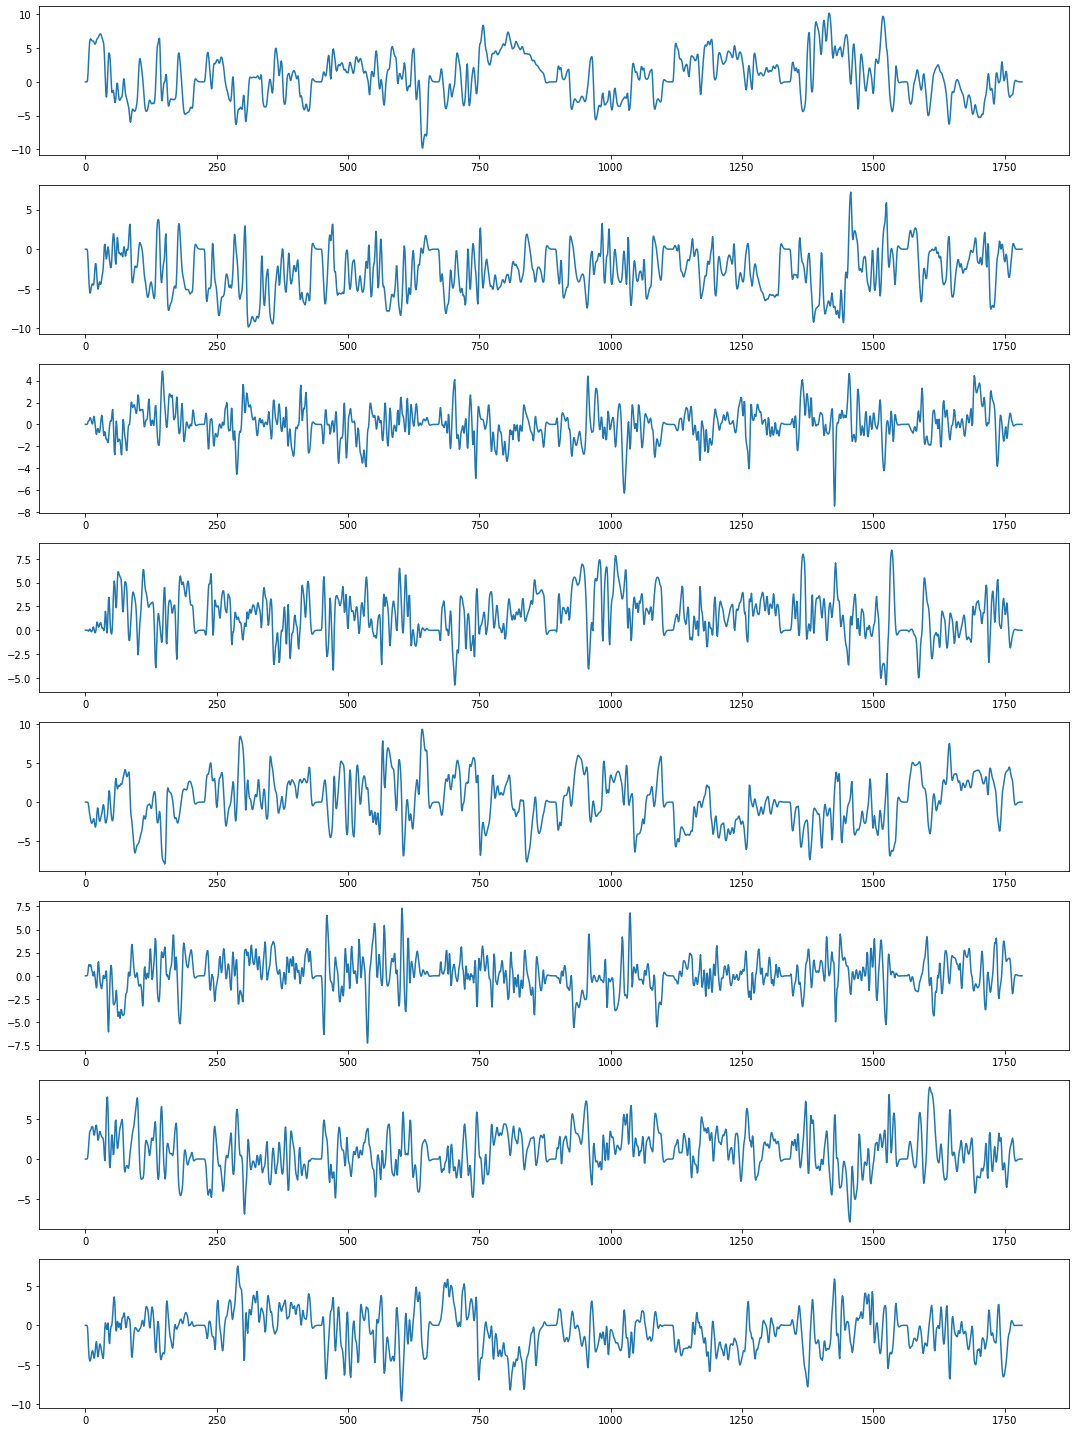

In [10]:
temp_design_matrix = design_matrix[:,-(num_latent_units):]
temp_data = temp_design_matrix[:,0:8]

n = temp_data.shape[1]
fig, axs = plt.subplots(n, 1,figsize=(15,20))
for i in range(n):
    tmp = temp_data[:,i]
    axs[i].plot(np.arange(len(tmp)), tmp)
    # axs[i].xaxis.set_ticks(np.arange(0, 200, 25) * 1.5)

fig.tight_layout()
plt.show()

#### save design matrix

In [11]:
from scipy.io import savemat
import copy

design_matrix_alltowns = copy.deepcopy(design_matrix)

matdic = {"design_matrix_alltowns":design_matrix_alltowns}

file_dir = os.path.join(processed_dir, "design_matrix")

savemat(os.path.join(file_dir, "design_matrix_alltowns_vit_latent_8.mat"), matdic)

# savemat(os.path.join(file_dir, "design_matrix_alltowns.mat"), matdic)
# savemat(os.path.join(file_dir, "design_matrix_alltowns_layer-"+str(i_layer)+"_dim-200.mat"), matdic)
# savemat(os.path.join(file_dir, "design_matrix_alltowns.mat"), matdic)


#### load design matrix

In [12]:
from scipy.io import loadmat

project_dir="/media/statespace/Spatial/sptialworkspace/spatialfMRI/fMRI_analysis/spatial_process"
processed_dir=project_dir+"/process/processed/autoencoder"
file_dir = os.path.join(processed_dir, "design_matrix")

matdic = loadmat(os.path.join(file_dir, "design_matrix_alltowns_vit_latent_8.mat"))

design_matrix_alltowns = matdic["design_matrix_alltowns"]
print("design matrix for all towns (n_TRs, n_latent_units) =", design_matrix_alltowns.shape)


design matrix for all towns (n_TRs, n_latent_units) = (1784, 19)


In [13]:
num_latent_units = num_latent_units
X_train = design_matrix_alltowns[0:223*6,-num_latent_units:]
X_town07 = design_matrix_alltowns[223*6:223*7,-num_latent_units:]
X_town08 = design_matrix_alltowns[223*7:223*8,-num_latent_units:]
print("X_town07 (n_TRs, n_latent_units) =", X_town07.shape)

X_town07 (n_TRs, n_latent_units) = (223, 8)


#### compare before and after hemodynamics

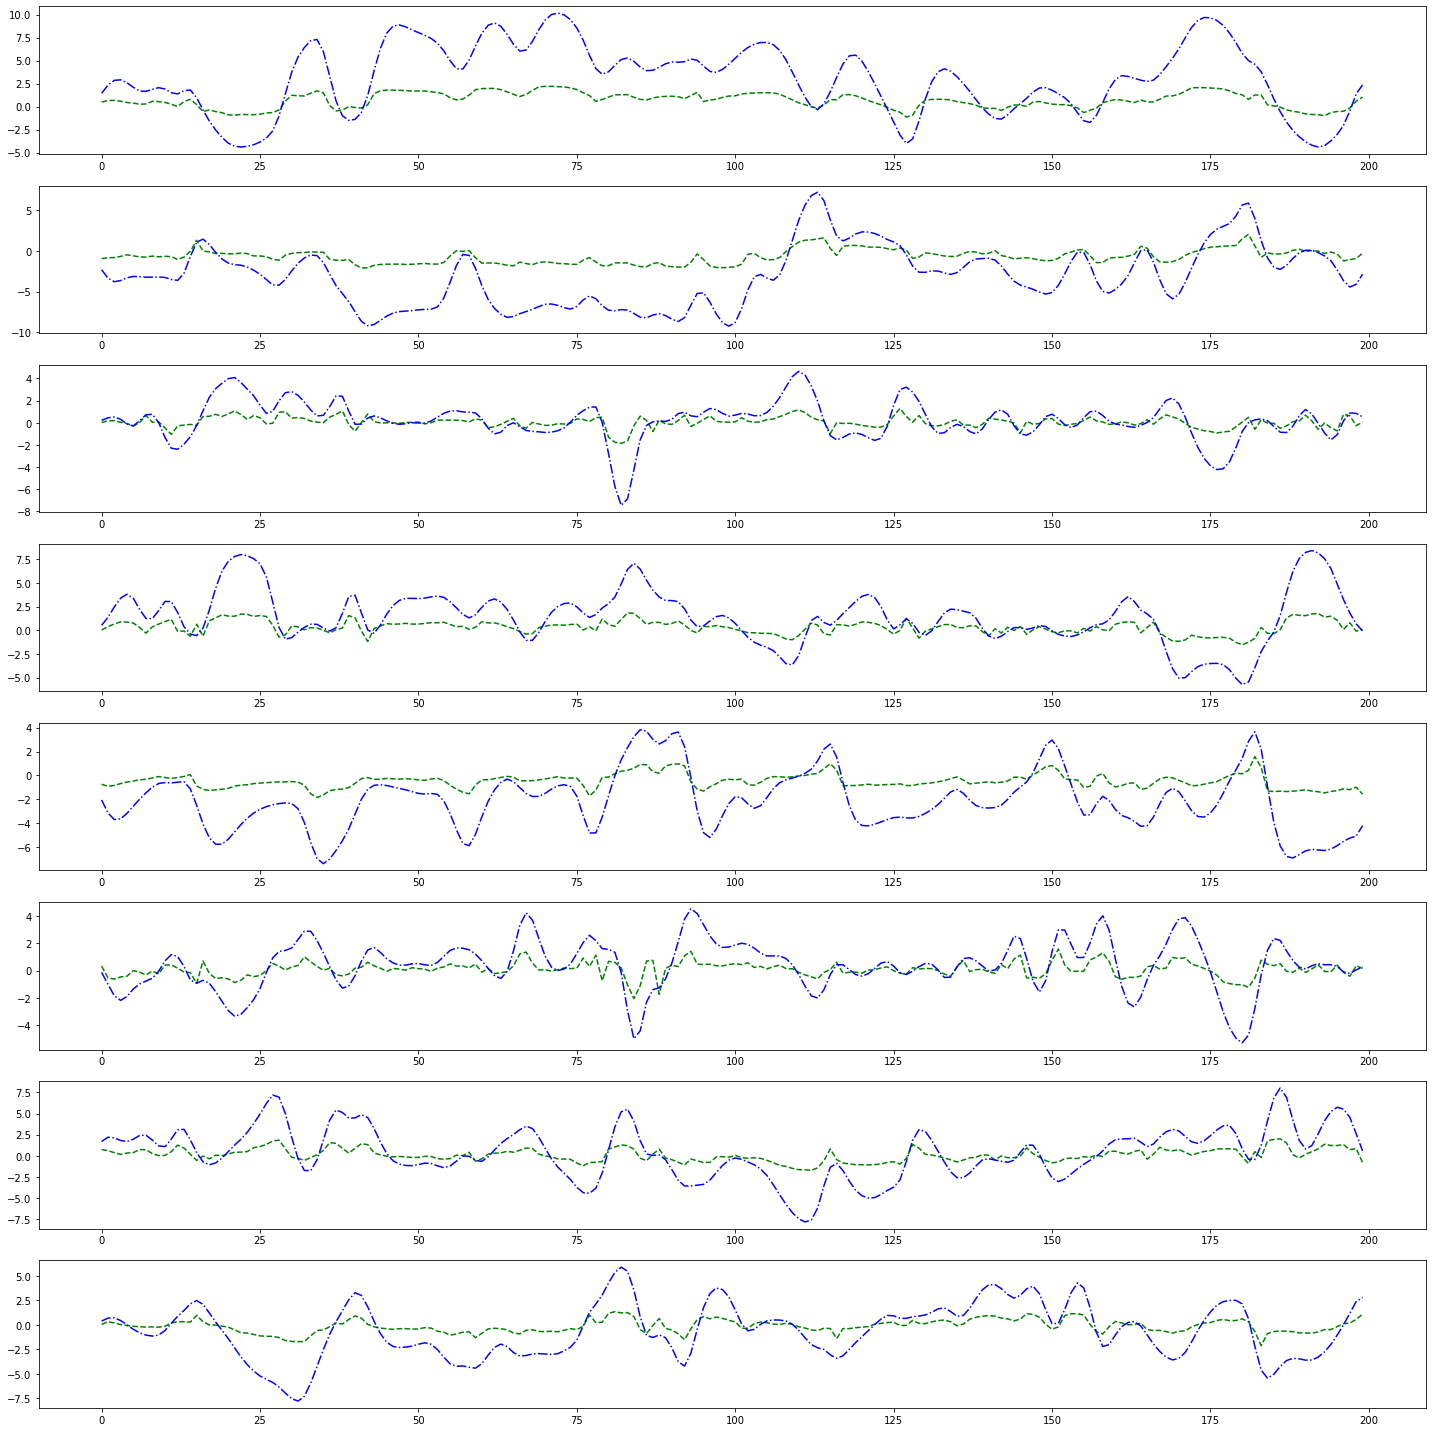

In [14]:
import matplotlib.pyplot as plt
import numpy as np

n = num_latent_units
fig, axs = plt.subplots(n, 1,figsize=(20,20))
for i in range(n):
    # tmp_decoded = decode_design_matrix[3:3+num_TRs_video,i]
    start_fixation_TRs = 3
    hemodynamic_shift_TRs = 3

    tmp_latent_units = units_latent_space[6,:,i]
    tmp_design_matrix = X_town07[start_fixation_TRs+hemodynamic_shift_TRs: \
                                start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video,i]
    # axs[i].plot(np.arange(num_TRs_video), tmp_decoded, 'r', label="decode", linestyle="-")
    axs[i].plot(np.arange(num_TRs_video), tmp_latent_units, 'g', label="latent unit", linestyle="--")
    axs[i].plot(np.arange(num_TRs_video), tmp_design_matrix,'b', label="design matrix", linestyle="-.")
    # axs[i].xaxis.set_ticks(np.arange(0, 200, 25) * 1.5)

fig.tight_layout()
plt.show()

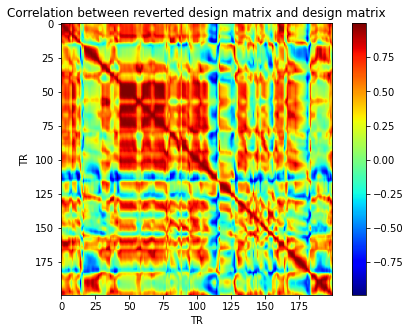

In [15]:
start_fixation_TRs = 3
hemodynamic_shift_TRs = 3

tmp_latent_units = units_latent_space[6,:,:]
tmp_design_matrix = X_town07[start_fixation_TRs+hemodynamic_shift_TRs: \
                              start_fixation_TRs+hemodynamic_shift_TRs+num_TRs_video,:]

cross_corr = np.corrcoef(tmp_latent_units, tmp_design_matrix)
plt.figure(figsize=(7,5))
plt.title('Correlation between reverted design matrix and design matrix')
plt.xlabel('TR')
plt.ylabel('TR')
plt.imshow(cross_corr[200:,:200], cmap='jet')
plt.colorbar()